In [1]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append('../../lib')

import os
import numpy as np

import LinOT
from LinOT.Visualization import *
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import json

from libSphere.Riem_Sphere import *
from libSphere.Visualization import *

# Rotating circle, muRef at North pole

In [3]:
R=1
discr=20000
rCircle=R*np.pi*.1
thetaNus=np.pi/10
thetaMuNu=np.pi*.5


vertMesh=sampleFromSphere(discr)
vertMesh*=R
north=np.array([0,0,R])
distances=dX(north,vertMesh,R,cross=True).flatten()
posMu=vertMesh[distances<=rCircle]
nPtsMu=posMu.shape[0]
mu=np.ones(nPtsMu)/nPtsMu

matTheta=np.array([[np.cos(thetaNus),-np.sin(thetaNus),0],[np.sin(thetaNus),np.cos(thetaNus),0],[0,0,1]])
matInit=np.array([[1,0,0],[0,np.cos(thetaMuNu),-np.sin(thetaMuNu)],[0,np.sin(thetaMuNu),np.cos(thetaMuNu)]])
posNu=np.einsum('ik,jk->ji',matInit,posMu)
posNus=[posNu]
nus=[np.ones(nPtsMu)/nPtsMu,]
nNus=20
for i in range(1,nNus):
    posNu=np.einsum('ik,jk->ji',matTheta,posNu)
    posNus.append(posNu)
    nus.append(np.ones(nPtsMu)/nPtsMu)

In [4]:
dataDir="data/RotatingCircleOnSphere/"

fileSamples = dataDir + "sampleDisks.npz"
fileCenter = dataDir + "centerTan.npz"

if not os.path.isdir(dataDir):
    os.mkdir(dataDir)


np.savez_compressed(fileSamples, *posNus)
np.savez(fileCenter, posMu=posMu)

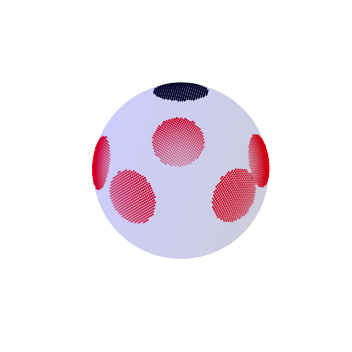

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

i = 0

plotSphere(ax,R,.1)

ax.scatter(posMu[:,0],posMu[:,1],posMu[:,2],c='k',s=1)

for posNu in posNus[::4]:
    ax.scatter(posNu[:,0],posNu[:,1],posNu[:,2],c='red',s=1)
    i+=1

ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=21, azim=-56)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## HK logs

In [6]:
params = {}


params["setup_HKScale"] = 4*R
params["solver_errorGoal"] = 1.E-6
params["solver_epsStart"] = 1.E2
params["solver_epsTarget"] = 1.E-4

fileParams=dataDir+'params.json'

with open(fileParams, 'w') as fp:
    json.dump(params, fp)

In [7]:
baseLog=lambda x,y:logX(x,y,rad=R,cross=True)

In [8]:
tanListV = []
tanListAlpha = []
for i in range(nNus):
    print(i)
    nu = nus[i]
    posNu = posNus[i]

    # solve HK transport
    cost=np.cos(np.minimum(dX(posMu,posNu,rad=R,cross=True)/params["setup_HKScale"],.5*np.pi))
    cost=-2.*(params["setup_HKScale"]**2)*np.log(np.maximum(1e-15,cost))
    
    value, piCSR = Sinkhorn.SolveOT(mu, nu, cost,
                                    SinkhornError=params["solver_errorGoal"],
                                    epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
                                    returnSolver=False,KLMarginals=True,kappa=params['setup_HKScale']**2
                                    )

    v, alpha = LinOT.LogHK(piCSR, mu, posMu, posNu, kappa=params["setup_HKScale"],baseLog=baseLog)
    tanListV.append(v)
    tanListAlpha.append(alpha)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [52]:
tanListV = np.array(tanListV)
tanListAlpha=np.array(tanListAlpha)
filename = dataDir + "tan_data_HK.npz"
np.savez_compressed(filename, tanListV=tanListV, tanListAlpha=tanListAlpha)